In [1]:
import pyspark
import os

from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import set_matplotlib_formats
import seaborn as sns
set_matplotlib_formats('svg')
%matplotlib inline
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [8., 5.]

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

os.environ["PYSPARK_PYTHON"]="python3"


### Нужно, используя Spark:

1. Найти явку (%) по всем регионам, результат отсортировать по убыванию.
2. Выбрать любимого кандидата и найти тот избирательный участок, на котором он получил наибольший результат (учитывать участки на которых проголосовало больше 300 человек).
3. Найти регион, где разница между ТИК с наибольшей явкой и наименьшей максимальна.
4. Посчитать дисперсию по явке для каждого региона (учитывать УИК).
5. Для каждого кандидата посчитать таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат.

In [2]:
spark = SparkSession \
    .builder \
    .appName("PySpark") \
    .getOrCreate()

In [3]:
ELECTIONS_FILE = 'UIK_table.csv'

schema= StructType([
            StructField("region",              StringType(), False), 
            StructField("tik",                 StringType(), False), 
            StructField("uik",                 StringType(), False), 
            StructField("voters_count",        IntegerType(), False),
            StructField("blanks_received",     IntegerType(), False),
            StructField("pre_voted_blanks",    IntegerType(), False),
            StructField("elec_day_blanks",     IntegerType(), False),
            StructField("not_elec_day_blanks", IntegerType(), False),
            StructField("cancel_blanks",       IntegerType(), False),
            StructField("tranf_box_blanks",    IntegerType(), False),
            StructField("stat_box_blanks",     IntegerType(), False),
            StructField("invalid_blanks",      IntegerType(), False),
            StructField("valid_blanks",        IntegerType(), False),
            StructField("lost_blanks",         IntegerType(), False),
            StructField("uncount_blanks",      IntegerType(), False),
            StructField("Baburin",               IntegerType(), False),
            StructField("Grudinin",                IntegerType(), False),
            StructField("Zhirinovsky",               IntegerType(), False),
            StructField("Putin",               IntegerType(), False),
            StructField("Sobchak",                IntegerType(), False),
            StructField("Suraikin",                 IntegerType(), False),
            StructField("Titov",               IntegerType(), False),
            StructField("Yavlinsky",                IntegerType(), False)]
        )

df = spark.read.csv(ELECTIONS_FILE, schema=schema)

1. Найти явку (%) по всем регионам, результат отсортировать по убыванию.

In [4]:
df.createOrReplaceTempView('election')

region_appearance = spark.sql(
    '''SELECT region, (SUM(tranf_box_blanks) + SUM(stat_box_blanks)) / SUM(voters_count) as appearance 
    FROM election
    GROUP BY region
    ORDER BY appearance DESC''')

region_appearance.show()

+--------------------+------------------+
|              region|        appearance|
+--------------------+------------------+
|     Республика Тыва|0.9362542974951742|
|Ямало-Ненецкий ав...|0.9187213306617982|
|Кабардино-Балкарс...| 0.916978754085207|
|Чеченская Республика|0.9150929703298174|
|Республика Северн...|0.8993704831730909|
| Республика Дагестан|0.8744351419820495|
|Карачаево-Черкесс...|0.8734380939009899|
| Кемеровская область|0.8307556958224817|
|Республика Адыгея...|0.8229772709642386|
|Чукотский автоном...|0.8226051697921947|
|Республика Ингушетия|0.8195937165135314|
|    Брянская область| 0.796597680757152|
|   Тюменская область|0.7888296737637491|
| Республика Мордовия|0.7783648793754097|
|  Краснодарский край|0.7783466166202626|
|Республика Татарс...|0.7736526548202729|
|Чувашская Республ...|0.7621061419670118|
|Республика Башкор...|0.7542120065745193|
|  Республика Бурятия|0.7519133382510174|
| Ставропольский край|0.7377007114684981|
+--------------------+------------

2. Выбрать любимого кандидата и найти тот избирательный участок, на котором он получил наибольший результат (учитывать участки на которых проголосовало больше 300 человек).

In [5]:
fav_cand = 'Grudinin'
fav_cand_results = spark.sql(f'''
SELECT region, tik, uik, {fav_cand}/voters_count as percent 
FROM election 
WHERE voters_count >= 300
ORDER BY percent DESC
''')
fav_cand_results.show(1)

+--------------------+----------+--------+------------------+
|              region|       tik|     uik|           percent|
+--------------------+----------+--------+------------------+
|Республика Северн...|Моздокская|УИК №149|0.5587266739846323|
+--------------------+----------+--------+------------------+
only showing top 1 row



3. Найти регион, где разница между ТИК с наибольшей явкой и наименьшей максимальна.

In [6]:
tik_appearance = spark.sql(f'''
SELECT region, MAX(appearance) - MIN(appearance) as diff
FROM
    (SELECT region, tik, (SUM(tranf_box_blanks) + SUM(stat_box_blanks)) / SUM(voters_count) as appearance
    FROM election
    GROUP BY region, tik)
GROUP BY region
ORDER BY diff DESC
''')
tik_appearance.show(1)

+--------------------+-------------------+
|              region|               diff|
+--------------------+-------------------+
|Архангельская обл...|0.49859164840684894|
+--------------------+-------------------+
only showing top 1 row



4. Посчитать дисперсию по явке для каждого региона (учитывать УИК).

In [7]:
appearance_var = spark.sql(f'''
SELECT region, STDDEV((tranf_box_blanks + stat_box_blanks) / voters_count) as var
FROM election 
GROUP BY region
ORDER BY var DESC
''')
appearance_var.show()

+--------------------+-------------------+
|              region|                var|
+--------------------+-------------------+
| Сахалинская область|0.20188798623588153|
|     Камчатский край|0.16873475777512104|
|  Мурманская область|0.16742131453895356|
|     Приморский край|0.16639015831512305|
|   Самарская область| 0.1562883627711597|
| Саратовская область|0.15426531267153376|
| Республика Калмыкия|0.15350844523090657|
| Воронежская область|0.14975754071870523|
| Магаданская область|0.14387651017723124|
|Республика Адыгея...| 0.1425498004402583|
|Республика Татарс...|0.14172353736111926|
|    Липецкая область|0.14096365252591128|
|Архангельская обл...| 0.1409455295612836|
|  Краснодарский край|  0.139465782255281|
|    Хабаровский край|0.13811595897262208|
|Белгородская область|0.13758282414787926|
| Ставропольский край|  0.134111904910141|
|  Республика Бурятия|0.13308253052737123|
|  Ростовская область|0.13138651268427395|
|Чувашская Республ...| 0.1304162760122735|
+----------

5. Для каждого кандидата посчитать таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат.

In [8]:
cand_dict = {}

candidates = ["Baburin", "Grudinin", "Zhirinovsky", "Putin", "Sobchak", "Suraikin", "Titov", "Yavlinsky"]

for cand in candidates:
    cand_dict[cand] = spark.sql(f'''
    SELECT percent, COUNT(percent) as num_uiks FROM
        (SELECT uik, int(100 * {cand} / voters_count) as percent
        FROM election)
    GROUP BY percent
    ORDER BY percent
    ''')

In [9]:
def plot_dist(name, dd):
    ls = []
    for row in dd[name].take(100):
        ls.extend([row[0]] * row[1])
    print(name)
    dd[name].show(100)
    fig, ax = plt.subplots()
    plt.title(name)
    sns.distplot(ls, ax=ax)

Baburin
+-------+--------+
|percent|num_uiks|
+-------+--------+
|      0|   91953|
|      1|    4431|
|      2|     513|
|      3|     152|
|      4|      70|
|      5|      30|
|      6|      21|
|      7|      16|
|      8|       8|
|      9|       5|
|     10|       8|
|     11|       2|
|     12|       1|
|     13|       1|
|     14|       3|
|     16|       2|
|     17|       1|
|     18|       1|
|     20|       2|
|     21|       1|
|     23|       1|
|     44|       1|
+-------+--------+



/home/ruslan/.local/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Grudinin
+-------+--------+
|percent|num_uiks|
+-------+--------+
|      0|    2449|
|      1|    3700|
|      2|    4332|
|      3|    5234|
|      4|    6941|
|      5|    9499|
|      6|   12083|
|      7|   12744|
|      8|   10951|
|      9|    7843|
|     10|    5728|
|     11|    3934|
|     12|    3019|
|     13|    2265|
|     14|    1533|
|     15|    1184|
|     16|     906|
|     17|     632|
|     18|     481|
|     19|     322|
|     20|     266|
|     21|     214|
|     22|     149|
|     23|     135|
|     24|     100|
|     25|     101|
|     26|      68|
|     27|      58|
|     28|      47|
|     29|      34|
|     30|      36|
|     31|      34|
|     32|      21|
|     33|      32|
|     34|      18|
|     35|      19|
|     36|      20|
|     37|       9|
|     38|      12|
|     39|       6|
|     40|       6|
|     41|       7|
|     42|       7|
|     43|       3|
|     44|       4|
|     45|       5|
|     46|       3|
|     47|       2|
|     48|       1|
|  

/home/ruslan/.local/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Titov
+-------+--------+
|percent|num_uiks|
+-------+--------+
|      0|   89847|
|      1|    6639|
|      2|     449|
|      3|     125|
|      4|      65|
|      5|      32|
|      6|      17|
|      7|      13|
|      8|      10|
|      9|       4|
|     10|       4|
|     11|       2|
|     12|       3|
|     13|       1|
|     14|       3|
|     15|       2|
|     16|       1|
|     17|       1|
|     18|       1|
|     20|       2|
|     23|       1|
|     29|       1|
+-------+--------+



/home/ruslan/.local/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Yavlinsky
+-------+--------+
|percent|num_uiks|
+-------+--------+
|      0|   82285|
|      1|   11155|
|      2|    2823|
|      3|     676|
|      4|     147|
|      5|      52|
|      6|      30|
|      7|      18|
|      8|      13|
|      9|       2|
|     10|      12|
|     11|       1|
|     13|       1|
|     14|       3|
|     16|       1|
|     18|       2|
|     19|       1|
|     21|       1|
+-------+--------+



/home/ruslan/.local/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


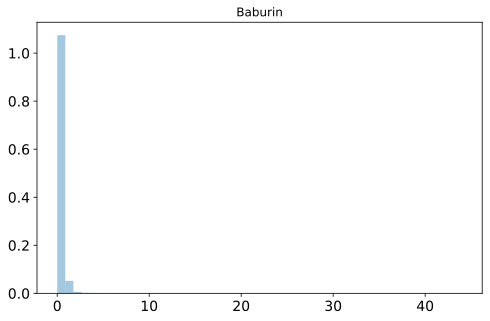

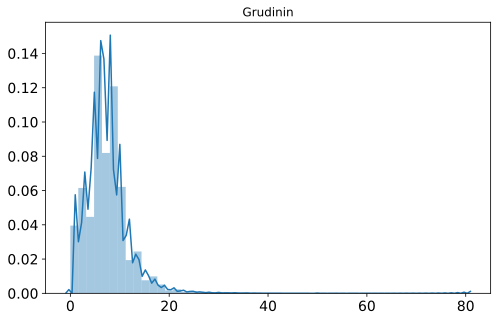

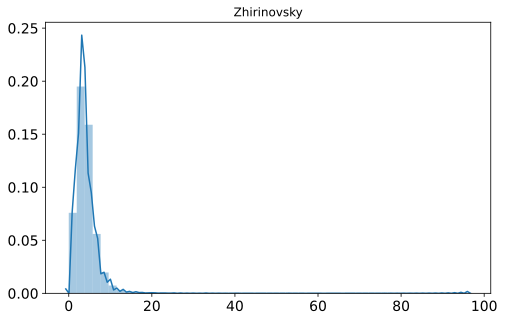

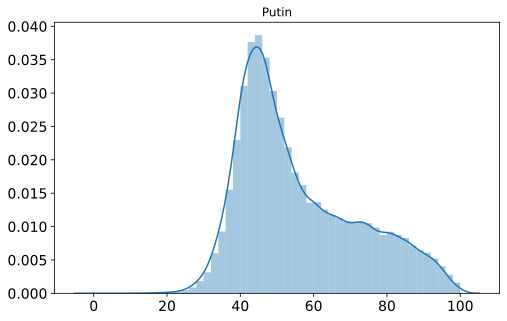

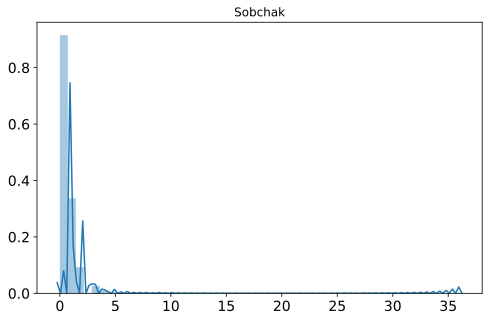

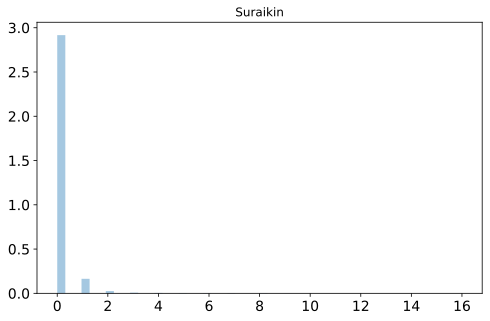

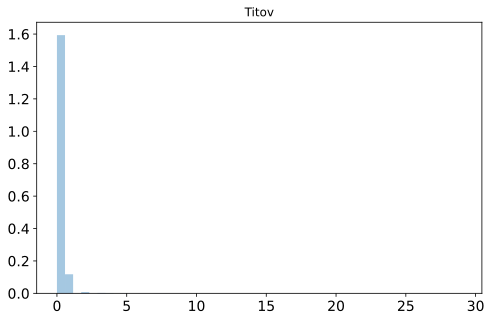

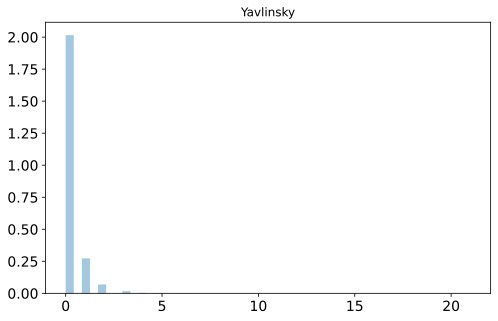

In [10]:
for item in cand_dict:
    plot_dist(item, cand_dict)